Borrowing heavily from https://casmls.github.io/general/2016/10/02/abc.html, instead of the variational objective we use a Stein Variational Gradient Descent.

The idea behind ABC is simply to replace an intractable likelihood with an estimate based on the distance between two datasets. Because time series have a natural ordering, given two data sets 

$$d_1,d_2,...,d_T$$
$$d'_1,d'_2,...,d'_T$$

We can easily compute the distance $K(\vec{d},\vec{d'})$ under a Gaussian kernel to get an estimate of the distance between the two datasets (unlike, say, an unordered dataset which would require a summary statistic since any permutation of the dataset would be valid) 


In order to evaluate the validity of such an approach we attempt to replicate some results found here:
http://kingaa.github.io/short-course/measles/measles.html

where the authors discover that particle based methods lead to poor estimate of $R_0$.


We first load the data (originally purposed for R) into python.




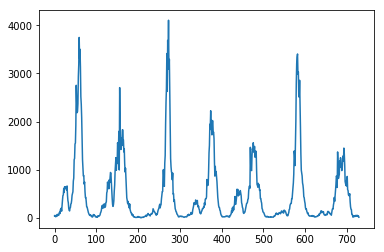

In [21]:
with open("/Users/gcgibson/Stein-Variational-Gradient-Descent/python/dat.json") as f:
    dat = f.read()
    
    
    dat = dat.split(",")
    time = []
    cases = []
    count = 0
    for elm in dat:
        if count % 2 ==0:
            time.append(elm.split(":")[1])
        else:
            cases.append(int(elm.split(":")[1].replace("}","").replace(']"]\n',"")))
        count +=1
        
import matplotlib.pyplot as plt

plt.plot(cases)
plt.show()

cases = cases[:100]

Seasonal SIR model taken from http://www.princeton.edu/~dobber/pub/Altizer_etal_EcolLtrs2006.pdf

In a first pass we choose to ignore the covariates and simply consider the SEIR model.

We first define a code block that is able to simulate trajectories from the SEIR model.


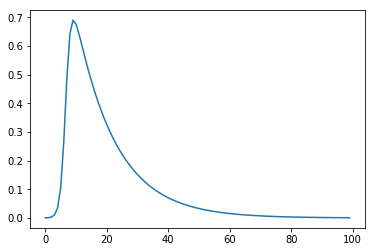

In [5]:
import scipy.integrate as spi
import numpy as np
import matplotlib.pyplot as plt




def diff_eqs(INP,t,beta0,beta1, gamma,mu):  
    '''The main set of equations'''
    Y=np.zeros((3))
    V = INP   
    beta=beta0*(1+beta1*np.sin(2*np.pi*t))
    Y[0] = mu - beta*V[0]*V[1] - mu*V[0]
    Y[1] = beta*V[0]*V[1] - mu*V[1] - gamma*V[1]
    Y[2] = gamma * V[1] - mu * V[2]
    return Y   # For odeint


def simulator(beta,gamma):
    beta0=beta
    
    beta1=0.1
    
    mu=.0001;
    S0=.9;
    I0=1e-4;
    INPUT=np.array((S0,I0, 1-S0-I0))

    ND=MaxTime= 100;
    TS=1.0
    t_start = 0.0; t_end = ND; t_inc = TS
    t_range = np.arange(t_start, t_end+t_inc, t_inc)
    RES = spi.odeint(diff_eqs,INPUT,t_range,args=(beta0,beta1, gamma,mu))
    return RES[1:,1]


plt.plot(simulator(1.4,1./13))
plt.show()

With an ability to sample from a deterministic SIR model, we can now use this as a plugin estimate of the likelihood under ABC. We implement the ABC-SMC sampler as in Toni et all 2009 in order to efficiently generate samples from the posterior.




In [53]:
##population ABC
import numpy as np
from numpy.random import choice
from scipy.stats import gamma
from scipy.stats import norm
import copy


etols = [1,.5,.1,.01,.001,.0001]

def prior_sample():
    return np.random.gamma(1,1,1)[0]
def prior_density(x):
    return gamma.pdf(x, 1, loc=1, scale=1)

def compute_distance(sim,cases):
    return np.power(sim-cases,2).sum()

compute_distance(simulator(1,.5),simulator(1,.5))

N = 100

current_weights = np.ones(N)/N
current_pop = []
t  = 0
for tol in etols:
    if t == 0:
        while len(current_pop) < N:
            possible_sample = [prior_sample(),prior_sample()]
            dist = compute_distance(simulator(possible_sample[0],possible_sample[1]),simulator(1,.5))
            if dist < tol:
                current_pop.append(possible_sample)
        t +=1
    else:
        previous_weights = copy.copy(current_weights)
        previous_pop = copy.copy(current_pop)

        for i in range(N):
            index = choice(range(N), 1, p=previous_weights)[0]
            current_pop[index] += np.random.normal(0,1,1)[0]
            
            normalizer = 0
            for j in range(N):
                #print (previous_weights[j])
                #print (norm.pdf(current_pop[index],previous_pop[j],1))
                normalizer += previous_weights[j]*norm.pdf(current_pop[index][0],previous_pop[j][0],1)*norm.pdf(current_pop[index][1],previous_pop[j][1],1)
            current_weights[index] = prior_density(previous_pop[index][0])*prior_density(previous_pop[index][1])/normalizer
        current_weights = current_weights/np.sum(current_weights)
            

In [54]:
current_pop = np.array(current_pop)

beta = np.mean(current_pop[:,0]*current_weights)
gamma = np.mean(current_pop[:,1]*current_weights)
print "Beta : ", beta
print "Gamma : ",gamma
print "R_0 : ", beta/gamma

Beta :  0.0533544009465465
Gamma :  0.04760288086935085
R_0 :  1.1208229412203237
